In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


## 1. Set up the SQLite database and create tables

In [5]:
conn = sqlite3.connect('student_grades.db')
cursor = conn.cursor()

# Create students table
cursor.execute('''
CREATE TABLE IF NOT EXISTS students (
    student_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT,
    last_name TEXT
)
''')

# Create grades table
cursor.execute('''
CREATE TABLE IF NOT EXISTS grades (
    grade_id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id INTEGER,
    subject TEXT,
    grade INTEGER,
    FOREIGN KEY (student_id) REFERENCES students(student_id)
)
''')


## 2. Insert sample data into tables

In [6]:

students = [
    ('Alice', 'Johnson'),
    ('Bob', 'Smith'),
    ('Carol', 'White'),
    ('David', 'Brown'),
    ('Eve', 'Davis')
]

grades = [
    (1, 'Math', 95),
    (1, 'English', 88),
    (1, 'History', 90),
    (2, 'Math', 82),
    (2, 'English', 76),
    (2, 'History', 85),
    (3, 'Math', 91),
    (3, 'English', 89),
    (3, 'History', 93),
    (4, 'Math', 84),
    (4, 'English', 78),
    (4, 'History', 80),
    (5, 'Math', 90),
    (5, 'English', 85),
    (5, 'History', 92)
]

cursor.executemany('INSERT INTO students (first_name, last_name) VALUES (?, ?)', students)
cursor.executemany('INSERT INTO grades (student_id, subject, grade) VALUES (?, ?, ?)', grades)

conn.commit()


## 3. SQL queries

In [7]:

# Retrieve all students' names and their grades
cursor.execute('''
SELECT first_name, last_name, subject, grade 
FROM students 
JOIN grades ON students.student_id = grades.student_id
''')
students_grades = cursor.fetchall()

# Average grade for each student
cursor.execute('''
SELECT first_name, last_name, AVG(grade) as avg_grade 
FROM students 
JOIN grades ON students.student_id = grades.student_id 
GROUP BY students.student_id
''')
average_grades = cursor.fetchall()

# Student with the highest average grade
cursor.execute('''
SELECT first_name, last_name, AVG(grade) as avg_grade 
FROM students 
JOIN grades ON students.student_id = grades.student_id 
GROUP BY students.student_id
ORDER BY avg_grade DESC
LIMIT 1
''')
highest_avg_student = cursor.fetchone()

# Average grade for Math subject
cursor.execute('''
SELECT AVG(grade) FROM grades WHERE subject = 'Math'
''')
avg_math_grade = cursor.fetchone()[0]

# List of students who scored above 90 in any subject
cursor.execute('''
SELECT first_name, last_name, subject, grade 
FROM students 
JOIN grades ON students.student_id = grades.student_id 
WHERE grade > 90
''')
high_scorers = cursor.fetchall()


## 4. Load data into Pandas and visualize

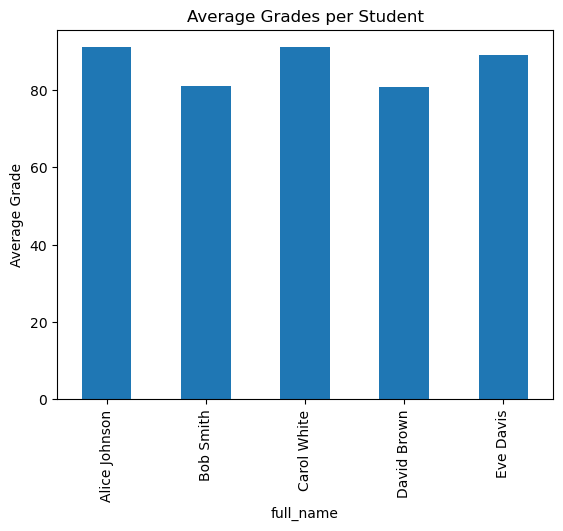

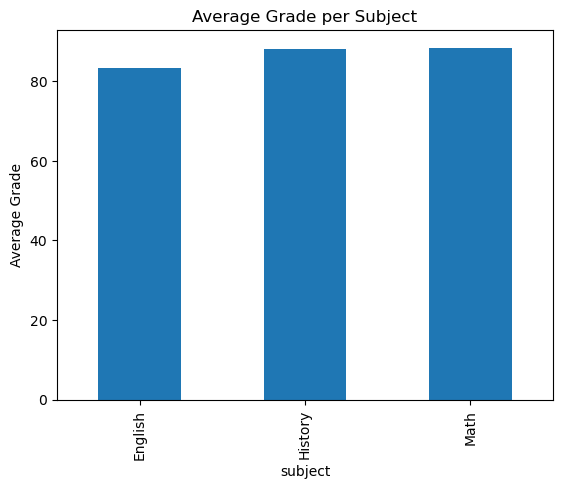

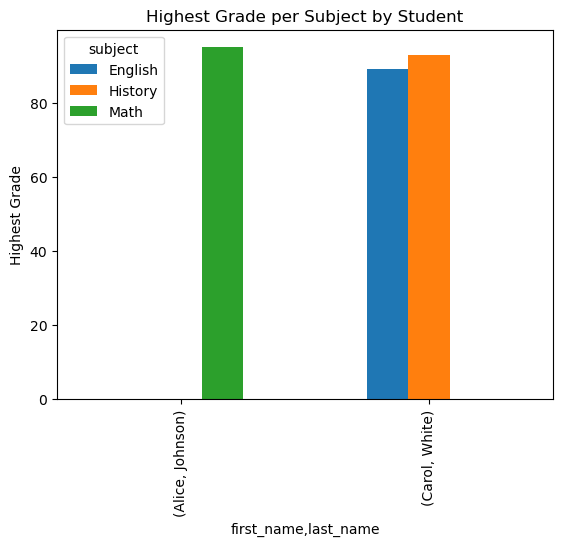

In [8]:

students_df = pd.read_sql_query('SELECT * FROM students', conn)
grades_df = pd.read_sql_query('SELECT * FROM grades', conn)

# Merge students and grades tables
merged_df = pd.read_sql_query('''
SELECT first_name, last_name, subject, grade 
FROM students 
JOIN grades ON students.student_id = grades.student_id
''', conn)

# Visualize average grades per student
avg_grades_df = merged_df.groupby(['first_name', 'last_name'])['grade'].mean().reset_index()

# Concatenate first_name and last_name into a single column for plotting
avg_grades_df['full_name'] = avg_grades_df['first_name'] + ' ' + avg_grades_df['last_name']

# Now plot with 'full_name' as the x-axis
avg_grades_df.plot(x='full_name', y='grade', kind='bar', legend=False)
plt.title('Average Grades per Student')
plt.ylabel('Average Grade')
plt.show()

# Bar chart showing average grade per subject
avg_subject_df = merged_df.groupby('subject')['grade'].mean().reset_index()
avg_subject_df.plot(x='subject', y='grade', kind='bar', legend=False)
plt.title('Average Grade per Subject')
plt.ylabel('Average Grade')
plt.show()

# Bonus: Student with the highest grade in each subject
cursor.execute('''
SELECT first_name, last_name, subject, MAX(grade) as max_grade 
FROM students 
JOIN grades ON students.student_id = grades.student_id 
GROUP BY subject
''')
highest_per_subject = cursor.fetchall()

# Visualize grouped bar chart for highest grades per subject
highest_per_subject_df = pd.DataFrame(highest_per_subject, columns=['first_name', 'last_name', 'subject', 'max_grade'])
highest_per_subject_df.pivot(index=['first_name', 'last_name'], columns='subject', values='max_grade').plot(kind='bar')
plt.title('Highest Grade per Subject by Student')
plt.ylabel('Highest Grade')
plt.show()

# Close the connection
conn.close()
